In [2]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

image_dir = "/kaggle/input/brain-tumor-segmentation/images"
mask_dir = "/kaggle/input/brain-tumor-segmentation/masks"

images = sorted(os.listdir(image_dir))

masks = sorted(os.listdir(mask_dir))

In [3]:
train_images, temp_images, train_masks, temp_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)


def move_images(subset: str):
    images, masks, path = subset
    os.makedirs(f"/kaggle/working/{path}/images", exist_ok=True)
    os.makedirs(f"/kaggle/working/{path}/masks", exist_ok=True)

    for img, mask in tqdm(zip(images, masks), total=len(images)):
        shutil.copy(os.path.join(image_dir, img), f"/kaggle/working/{path}/images/")
        shutil.copy(os.path.join(mask_dir, mask), f"/kaggle/working/{path}/masks/")


for subset in (
    (train_images, train_masks, "train"),
    (val_images, val_masks, "val"),
    (test_images, test_masks, "test"),
):
    move_images(subset)

100%|██████████| 307/307 [00:06<00:00, 47.66it/s]


In [4]:
import albumentations as A
import cv2
import torch
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

BATCH_SIZE = 32

# датасет для загрузки данных


class TumorDataset(Dataset):
    def __init__(self, img_dir: str, mask_dir: str, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_files = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        mask_path = os.path.join(
            self.mask_dir, self.img_files[idx].replace(".jpg", ".png")
        )
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        transformed = self.transform(image=img, mask=mask)
        img = transformed["image"]
        mask = transformed["mask"].unsqueeze(0)
        mask = (mask > 0).float()
        return img, mask


# функция для преобразования данных
def create_transform(size: tuple[int] = (256, 256), normalize=None):
    transform_steps = [A.Resize(size), A.HorizontalFlip(), A.VerticalFlip()]
    if normalize:
        transform_steps.append(
            A.Normalize(mean=normalize["mean"], std=normalize["std"])
        )
    transform_steps.append(ToTensorV2())
    return A.Compose(transform_steps)


train_transform = create_transform(
    normalize={"mean": [0.5, 0.5, 0.5], "std": [1, 1, 1]}
)
test_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=[0.5, 0.5, 0.5], std=[1, 1, 1]), ToTensorV2()]
)


def get_transform(phase):
    if phase == "train":
        return train_transform
    else:
        return test_transform


data_dirs = {
    "train": {
        "img_dir": "/kaggle/working/train/images",
        "mask_dir": "/kaggle/working/train/masks",
    },
    "val": {
        "img_dir": "/kaggle/working/val/images",
        "mask_dir": "/kaggle/working/val/masks",
    },
    "test": {
        "img_dir": "/kaggle/working/test/images",
        "mask_dir": "/kaggle/working/test/masks",
    },
}

datasets = {
    phase: TumorDataset(
        img_dir=dirs["img_dir"],
        mask_dir=dirs["mask_dir"],
        transform=get_transform(phase),
    )
    for phase, dirs in data_dirs.items()
}

dataloaders = {
    "train": torch.utils.data.DataLoader(
        datasets["train"], batch_size=BATCH_SIZE, shuffle=True
    ),
    "val": torch.utils.data.DataLoader(
        datasets["val"], batch_size=BATCH_SIZE, shuffle=False
    ),
    "test": torch.utils.data.DataLoader(
        datasets["test"], batch_size=BATCH_SIZE, shuffle=False
    ),
}

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
def visualize_images_with_masks(
    data_loader: DataLoader, num_samples: int = 4, overlay: bool = False
):
    """
    Visualize a batch of images with their corresponding masks.

    Args:
        data_loader : DataLoader - DataLoader for the dataset.
        num_samples : int - Number of samples to visualize.
        overlay : bool - If True, overlay masks on images for visualization.
    """
    batch = next(iter(data_loader))
    images, masks = batch
    images = images[:num_samples]
    masks = masks[:num_samples]

    plt.figure(figsize=(12, num_samples * 3))
    for i in range(num_samples):
        if overlay:
            overlay_img = images[i].permute(1, 2, 0).numpy()
            overlay_mask = masks[i][0].numpy()

            plt.subplot(num_samples, 1, i + 1)
            plt.imshow(overlay_img)
            plt.imshow(overlay_mask, cmap="jet", alpha=0.5)
            plt.title("Image with Mask Overlay")
            plt.axis("off")
        else:
            plt.subplot(num_samples, 2, i * 2 + 1)
            plt.imshow(images[i].permute(1, 2, 0).numpy())
            plt.title("Image")
            plt.axis("off")

            plt.subplot(num_samples, 2, i * 2 + 2)
            plt.imshow(masks[i][0].numpy(), cmap="gray")
            plt.title("Mask")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

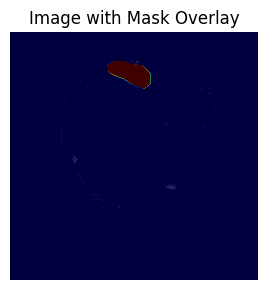

In [6]:
import matplotlib.pyplot as plt

visualize_images_with_masks(dataloaders["train"], 1, True)

In [8]:
import pyro
import pyro.distributions as dist
import pyro.nn as pnn
import torch.nn as nn
from pyro.nn import PyroModule, PyroSample

class ConvBlock(PyroModule):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bayesian: bool = False,
        distributions: dict = {},
    ):
        super().__init__()
        self.block = PyroModule[nn.Sequential](
            PyroModule[nn.Conv2d](in_features, out_features, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            PyroModule[nn.Conv2d](out_features, out_features, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
        )

        if bayesian:
            self.add_bayesian_weights(distributions)

    def forward(self, x):
        return self.block(x)

    def add_bayesian_weights(self, distributions: dict):
        """
        Заменяет веса модели вероятностыми распределениями.
        distributions: заданные пользователем распределения (иначе используются нормальные)
        """
        if "conv1" not in distributions:
            distributions["conv1"] = dist.Normal(
                torch.tensor(0.0, device=device), torch.tensor(1.0, device=device)
            )
        if "conv2" not in distributions:
            distributions["conv2"] = dist.Normal(
                torch.tensor(0.0, device=device), torch.tensor(1.0, device=device)
            )

        conv1_dim = self.block[0].weight.size()
        conv2_dim = self.block[3].weight.size()
        self.block[0].weight = PyroSample(
            distributions["conv1"].expand(conv1_dim).to_event(4)
        )
        self.block[3].weight = PyroSample(
            distributions["conv2"].expand(conv2_dim).to_event(4)
        )


class UpConvBlock(PyroModule):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bayesian: bool = False,
        distributions: dict = {},
    ):
        super().__init__()
        self.upscale = PyroModule[nn.ConvTranspose2d](
            in_features, out_features, 2, stride=2
        )
        self.block = ConvBlock(out_features * 2, out_features, bayesian, distributions)

        if bayesian:
            self.add_bayesian_weights(distributions)

    def forward(self, x, encoder_map):
        x = self.upscale(x)
        x = torch.cat([x, encoder_map], dim=1)
        return self.block(x)

    def add_bayesian_weights(self, distributions: dict):
        """
        Заменяет веса модели вероятностыми распределениями.
        distributions: заданные пользователем распределения (иначе используются нормальные)
        """
        if "upconv" not in distributions:
            distributions["upconv"] = dist.Normal(
                torch.tensor(0.0, device=device), torch.tensor(1.0, device=device)
            )

        upscale_dim = self.upscale.weight.size()
        self.upscale.weight = PyroSample(
            distributions["conv1"].expand(upscale_dim).to_event(4)
        )


class Unet(PyroModule):
    def __init__(self, bayesian: bool = False, distributions: dict = {}):
        super().__init__()
        self.max_pool = nn.MaxPool2d(2)

        for key in [f"block{i}" for i in range(1, 5 + 1)]:
            if key not in distributions:
                distributions[key] = {}
        for key in [f"up_block{i}" for i in range(1, 4 + 1)]:
            if key not in distributions:
                distributions[key] = {}

        self.block1 = PyroModule[ConvBlock](3, 32, bayesian, distributions["block1"])
        self.block2 = PyroModule[ConvBlock](32, 64, bayesian, distributions["block2"])
        self.block3 = PyroModule[ConvBlock](64, 128, bayesian, distributions["block3"])
        self.block4 = PyroModule[ConvBlock](128, 256, bayesian, distributions["block4"])
        self.block5 = PyroModule[ConvBlock](256, 512, bayesian, distributions["block5"])

        self.up_block1 = PyroModule[UpConvBlock](
            512, 256, bayesian, distributions["up_block1"]
        )
        self.up_block2 = PyroModule[UpConvBlock](
            256, 128, bayesian, distributions["up_block2"]
        )
        self.up_block3 = PyroModule[UpConvBlock](
            128, 64, bayesian, distributions["up_block3"]
        )
        self.up_block4 = PyroModule[UpConvBlock](
            64, 32, bayesian, distributions["up_block4"]
        )

        if bayesian:
            self.segment_conv = PyroModule[nn.Sequential](
                PyroModule[nn.Conv2d](32, 1, 3, stride=1, padding=1), nn.Sigmoid()
            )
            self.add_bayesian_weights(distributions)

        else:
            self.segment_conv = nn.Conv2d(32, 1, 3, stride=1, padding=1)

        self.bayesian = bayesian

    def forward(self, x, y=None):
        xe1 = self.block1(x)
        xe1m = self.max_pool(xe1)

        xe2 = self.block2(xe1m)
        xe2m = self.max_pool(xe2)

        xe3 = self.block3(xe2m)
        xe3m = self.max_pool(xe3)

        xe4 = self.block4(xe3m)
        xe4m = self.max_pool(xe4)

        xe5 = self.block5(xe4m)
        xd1 = self.up_block1(xe5, xe4)
        xd2 = self.up_block2(xd1, xe3)
        xd3 = self.up_block3(xd2, xe2)
        xd4 = self.up_block4(xd3, xe1)
        xd5 = self.segment_conv(xd4)

        # xd5 - вероятность для каждого пикселя в распределении Бернули
        # поэтому каждый пиксель просэмплируем, чтобы получить
        # оценку неопределенности
        # .plate - указываем, что у нас батч независимых наблюдений

        # пиксели - зависимые случайные величины, поэтому укажем
        # это в .to_event(3) - последние 3 координаты из одного распределения
        if self.bayesian:
            # print("Observed Tensor y:", y.min().item(), y.max().item())
            # print("Segment Conv Output:", xd5.min().item(), xd5.max().item())
            with pyro.plate("data", x.size(0)):
                obs = pyro.sample("obs", dist.Bernoulli(probs=xd5).to_event(3), obs=y)
                return obs
        else:
            return xd5

    def add_bayesian_weights(self, distributions: dict):
        """
        Заменяет веса модели вероятностыми распределениями.
        distributions: заданные пользователем распределения (иначе используются нормальные)
        """
        if "segment_conv" not in distributions:
            distributions["segment_conv"] = dist.Normal(
                torch.tensor(0.0, device=device), torch.tensor(1.0, device=device)
            )

        segment_conv_dim = self.segment_conv[0].weight.size()

        self.segment_conv[0].weight = PyroSample(
            (distributions["segment_conv"].expand(segment_conv_dim).to_event(4))
        )


device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = Unet(bayesian=True)

Вариационный вывод

In [12]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

pyro.clear_param_store()
pyro.set_rng_seed(1)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

optimizer = Adam({"lr": 0.001})
bmodel = Unet(bayesian=True).to(device)
guide = AutoDiagonalNormal(bmodel).to(device) # аппроксимация стандартным распределением
elbo = Trace_ELBO() # оптимизация ELBO
svi = SVI(bmodel, guide, optimizer, loss=elbo) # вариационный вывод
train_losses = []
val_losses = []

# Early stopping parameters
patience = 10
tolerance = 100
best_val_loss = float("inf")
no_improvement_count = 0

for step in range(500):
    loss = 0
    for x, y in tqdm(dataloaders["train"]):
        x = x.to(device)
        y = y.to(device)
        loss += svi.step(x, y)
    train_losses.append(loss / (BATCH_SIZE * len(dataloaders["train"])))

    with torch.no_grad():
        loss = 0
        for x, y in tqdm(dataloaders["val"]):
            x = x.to(device)
            y = y.to(device)
            loss += svi.evaluate_loss(x, y)
        val_losses.append(loss / (BATCH_SIZE * len(dataloaders["val"])))

    print(
        "[iteration %04d] train loss: %.4f, val loss: %.4f"
        % (step + 1, train_losses[-1], val_losses[-1])
    )

    # Check for improvement
    if val_losses[-1] < best_val_loss - tolerance:
        best_val_loss = val_losses[-1]
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # Early stopping condition
    if no_improvement_count >= patience:
        print("Early stopping triggered at iteration %04d" % (step + 1))
        break

100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0001] train loss: 458007.6046, val loss: 444811.2562


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0002] train loss: 438273.7284, val loss: 430613.3578


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0003] train loss: 423715.5424, val loss: 415806.3531


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


[iteration 0004] train loss: 408745.2980, val loss: 400886.1047


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0005] train loss: 393757.6326, val loss: 386017.1500


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


[iteration 0006] train loss: 379549.5919, val loss: 372287.2219


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0007] train loss: 365948.4031, val loss: 358958.4125


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0008] train loss: 352658.6438, val loss: 345909.1961


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0009] train loss: 339843.6331, val loss: 333206.1914


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


[iteration 0010] train loss: 327409.9172, val loss: 320869.7664


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


[iteration 0011] train loss: 315177.7950, val loss: 308863.3242


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


[iteration 0012] train loss: 303360.8695, val loss: 297230.0391


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


[iteration 0013] train loss: 291746.8192, val loss: 285849.7676


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


[iteration 0014] train loss: 280465.7991, val loss: 274719.7652


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


[iteration 0015] train loss: 269448.9498, val loss: 263858.4086


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


[iteration 0016] train loss: 258699.5825, val loss: 253279.7036


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


[iteration 0017] train loss: 248312.1496, val loss: 242909.5049


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


[iteration 0018] train loss: 238159.5137, val loss: 233022.7932


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


[iteration 0019] train loss: 228391.5644, val loss: 223340.1855


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0020] train loss: 218935.5803, val loss: 214083.8943


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0021] train loss: 209746.0326, val loss: 205063.0539


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0022] train loss: 200973.2155, val loss: 196535.1805


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0023] train loss: 192439.7058, val loss: 188072.1367


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0024] train loss: 184249.7801, val loss: 180038.1605


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0025] train loss: 176377.9604, val loss: 172369.1023


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0026] train loss: 168798.6556, val loss: 165040.8445


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0027] train loss: 161582.7557, val loss: 157919.3094


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0028] train loss: 154625.7799, val loss: 151035.7266


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


[iteration 0029] train loss: 147994.0481, val loss: 144549.4555


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0030] train loss: 141657.7083, val loss: 138368.7172


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0031] train loss: 135597.0078, val loss: 132487.8719


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0032] train loss: 129823.1667, val loss: 126739.5547


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0033] train loss: 124324.4305, val loss: 121474.1453


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0034] train loss: 119107.3179, val loss: 116350.8125


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0035] train loss: 114100.1070, val loss: 111494.4297


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0036] train loss: 109375.4682, val loss: 106887.8250


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0037] train loss: 104871.5903, val loss: 102475.5406


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0038] train loss: 100604.8457, val loss: 98393.2875


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0039] train loss: 96532.0148, val loss: 94355.5719


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0040] train loss: 92607.2450, val loss: 90541.7047


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0041] train loss: 88944.8250, val loss: 87021.6469


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0042] train loss: 85455.3450, val loss: 83724.1344


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0043] train loss: 82146.6392, val loss: 80381.8031


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0044] train loss: 78998.5957, val loss: 77293.0406


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0045] train loss: 75998.3059, val loss: 74389.1906


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0046] train loss: 73139.6563, val loss: 71506.2625


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0047] train loss: 70439.7310, val loss: 68872.9250


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0048] train loss: 67855.8682, val loss: 66428.3641


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0049] train loss: 65408.2626, val loss: 63974.6047


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


[iteration 0050] train loss: 63047.7996, val loss: 61808.5234


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


[iteration 0051] train loss: 60868.1119, val loss: 59606.9594


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0052] train loss: 58719.4676, val loss: 57562.3703


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0053] train loss: 56721.1199, val loss: 55566.3859


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0054] train loss: 54849.5000, val loss: 53754.9031


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0055] train loss: 53001.8967, val loss: 51989.1859


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0056] train loss: 51278.7202, val loss: 50373.1406


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0057] train loss: 49669.8198, val loss: 48659.0938


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0058] train loss: 48043.4144, val loss: 47059.9828


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0059] train loss: 46560.4952, val loss: 45633.0797


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0060] train loss: 45090.6174, val loss: 44205.7172


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0061] train loss: 43748.4610, val loss: 42925.4109


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0062] train loss: 42439.2003, val loss: 41691.8109


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0063] train loss: 41187.0283, val loss: 40380.1906


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0064] train loss: 40020.1481, val loss: 39357.7906


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


[iteration 0065] train loss: 38849.6369, val loss: 38113.2484


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0066] train loss: 37733.3415, val loss: 36981.5969


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


[iteration 0067] train loss: 36686.6359, val loss: 36045.9344


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0068] train loss: 35663.5369, val loss: 34996.9313


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0069] train loss: 34726.1015, val loss: 34146.6937


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0070] train loss: 33815.9750, val loss: 33238.3500


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


[iteration 0071] train loss: 32944.4493, val loss: 32292.1125


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0072] train loss: 32089.4089, val loss: 31583.8625


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


[iteration 0073] train loss: 31257.0480, val loss: 30660.5219


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0074] train loss: 30436.6958, val loss: 29886.3187


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0075] train loss: 29694.4847, val loss: 29186.9375


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0076] train loss: 28969.5808, val loss: 28481.0031


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0077] train loss: 28299.1241, val loss: 27820.3781


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0078] train loss: 27594.2768, val loss: 27157.0812


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0079] train loss: 26976.2653, val loss: 26458.7625


100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


[iteration 0080] train loss: 26362.4406, val loss: 25813.4062


100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


[iteration 0081] train loss: 25730.6686, val loss: 25296.8406


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


[iteration 0082] train loss: 25143.5566, val loss: 24795.7969


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0083] train loss: 24564.6702, val loss: 24193.8781


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0084] train loss: 24015.8894, val loss: 23722.7469


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0085] train loss: 23501.7077, val loss: 23108.0594


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0086] train loss: 22983.2102, val loss: 22720.3937


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0087] train loss: 22539.8983, val loss: 22155.6063


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0088] train loss: 22034.8571, val loss: 21646.2687


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0089] train loss: 21604.6059, val loss: 21232.6250


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0090] train loss: 21192.2007, val loss: 20742.8719


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0091] train loss: 20750.3719, val loss: 20450.2500


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


[iteration 0092] train loss: 20353.1904, val loss: 19909.0719


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


[iteration 0093] train loss: 19954.8570, val loss: 19502.1937


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0094] train loss: 19589.1784, val loss: 19197.8125


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0095] train loss: 19230.9418, val loss: 18869.8187


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0096] train loss: 18859.8742, val loss: 18541.3375


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0097] train loss: 18507.6230, val loss: 18206.9813


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


[iteration 0098] train loss: 18175.5559, val loss: 17901.5187


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


[iteration 0099] train loss: 17851.9807, val loss: 17503.8187


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0100] train loss: 17506.6455, val loss: 17239.1250


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0101] train loss: 17204.1431, val loss: 16892.9125


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0102] train loss: 16880.8871, val loss: 16688.6375


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0103] train loss: 16678.8861, val loss: 16311.8312


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0104] train loss: 16337.1897, val loss: 16100.0875


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0105] train loss: 16109.6048, val loss: 15744.3000


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0106] train loss: 15815.1656, val loss: 15553.2719


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0107] train loss: 15571.4082, val loss: 15247.1969


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0108] train loss: 15319.6071, val loss: 14981.7469


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0109] train loss: 15070.3116, val loss: 14964.5312


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


[iteration 0110] train loss: 14822.7077, val loss: 14567.4406


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0111] train loss: 14608.4026, val loss: 14319.3969


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0112] train loss: 14379.1628, val loss: 14098.8250


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0113] train loss: 14147.8244, val loss: 13900.0969


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


[iteration 0114] train loss: 13950.4454, val loss: 13700.6250


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


[iteration 0115] train loss: 13779.6674, val loss: 13476.4781


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


[iteration 0116] train loss: 13586.6107, val loss: 13356.0531


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0117] train loss: 13375.5385, val loss: 13110.6812


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0118] train loss: 13217.9267, val loss: 12856.4781


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0119] train loss: 13012.9075, val loss: 12740.4219


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0120] train loss: 12808.9717, val loss: 12598.1625


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0121] train loss: 12630.8600, val loss: 12459.3906


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


[iteration 0122] train loss: 12479.8795, val loss: 12239.7031


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


[iteration 0123] train loss: 12315.8111, val loss: 12122.4906


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


[iteration 0124] train loss: 12135.6239, val loss: 11879.9031


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0125] train loss: 11988.4188, val loss: 11742.2437


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0126] train loss: 11820.1982, val loss: 11688.6969


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


[iteration 0127] train loss: 11681.4271, val loss: 11503.2219


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0128] train loss: 11536.6740, val loss: 11316.3687


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0129] train loss: 11397.4283, val loss: 11151.6375


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0130] train loss: 11218.1444, val loss: 11117.6437


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0131] train loss: 11114.2938, val loss: 10962.0031


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0132] train loss: 10987.9273, val loss: 10836.2812


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0133] train loss: 10866.8738, val loss: 10535.5438


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0134] train loss: 10764.9983, val loss: 10514.8500


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0135] train loss: 10614.6263, val loss: 10329.6906


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0136] train loss: 10478.6255, val loss: 10202.2812


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0137] train loss: 10373.2137, val loss: 10069.1000


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0138] train loss: 10282.3563, val loss: 9987.3156


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0139] train loss: 10113.1822, val loss: 9962.7687


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


[iteration 0140] train loss: 10012.9440, val loss: 9747.8625


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


[iteration 0141] train loss: 9934.6527, val loss: 9762.7625


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


[iteration 0142] train loss: 9821.5465, val loss: 9580.1875


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0143] train loss: 9748.5269, val loss: 9482.0250


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


[iteration 0144] train loss: 9617.8928, val loss: 9336.8375


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0145] train loss: 9532.3127, val loss: 9362.5531


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0146] train loss: 9424.9533, val loss: 9160.8906


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0147] train loss: 9353.6242, val loss: 9184.3500


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0148] train loss: 9256.3593, val loss: 9034.6375


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0149] train loss: 9175.3476, val loss: 8970.6812


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0150] train loss: 9064.4840, val loss: 8852.7000


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


[iteration 0151] train loss: 8981.0072, val loss: 8878.9000


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0152] train loss: 8905.3041, val loss: 8675.6344


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


[iteration 0153] train loss: 8803.5622, val loss: 8679.4312


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0154] train loss: 8740.7667, val loss: 8483.3250


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


[iteration 0155] train loss: 8685.6928, val loss: 8486.7406


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0156] train loss: 8544.2266, val loss: 8408.1719


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


[iteration 0157] train loss: 8529.0185, val loss: 8258.6875


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0158] train loss: 8410.7677, val loss: 8274.2469


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0159] train loss: 8386.4503, val loss: 8167.8250


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0160] train loss: 8289.2733, val loss: 8137.4563


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0161] train loss: 8214.7917, val loss: 8048.8313


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0162] train loss: 8104.7117, val loss: 7955.8500


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0163] train loss: 8081.3093, val loss: 7836.2469


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


[iteration 0164] train loss: 7996.2507, val loss: 7766.4656


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0165] train loss: 7920.1033, val loss: 7774.4969


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0166] train loss: 7905.5202, val loss: 7737.2000


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0167] train loss: 7804.6872, val loss: 7618.1250


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0168] train loss: 7726.0925, val loss: 7524.9031


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0169] train loss: 7702.2434, val loss: 7494.7500


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0170] train loss: 7630.6900, val loss: 7436.7344


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0171] train loss: 7568.9561, val loss: 7322.0719


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0172] train loss: 7483.1153, val loss: 7319.8094


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0173] train loss: 7419.3175, val loss: 7188.1719


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0174] train loss: 7415.5523, val loss: 7160.7656


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0175] train loss: 7340.8717, val loss: 7132.8125


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0176] train loss: 7298.3759, val loss: 7184.0437


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


[iteration 0177] train loss: 7215.6062, val loss: 7050.5750


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0178] train loss: 7189.8729, val loss: 6874.1500


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0179] train loss: 7135.7497, val loss: 6982.6156


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0180] train loss: 7077.8885, val loss: 6872.3344


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0181] train loss: 7034.9539, val loss: 6837.7250


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


[iteration 0182] train loss: 6973.9597, val loss: 6759.4469


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


[iteration 0183] train loss: 6939.4475, val loss: 6762.5531


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


[iteration 0184] train loss: 6921.8552, val loss: 6681.6219


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0185] train loss: 6841.0118, val loss: 6615.5500


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0186] train loss: 6806.3265, val loss: 6623.2281


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0187] train loss: 6756.6864, val loss: 6611.0688


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0188] train loss: 6691.4779, val loss: 6567.3344


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0189] train loss: 6662.0311, val loss: 6485.3094


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0190] train loss: 6650.4645, val loss: 6500.4062


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


[iteration 0191] train loss: 6584.5860, val loss: 6344.1687


100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


[iteration 0192] train loss: 6517.9544, val loss: 6334.0594


100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


[iteration 0193] train loss: 6465.2989, val loss: 6326.1812


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


[iteration 0194] train loss: 6466.1598, val loss: 6256.7375


100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


[iteration 0195] train loss: 6413.5955, val loss: 6135.8969


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


[iteration 0196] train loss: 6376.8380, val loss: 6188.5219


100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


[iteration 0197] train loss: 6329.5923, val loss: 6165.2625


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


[iteration 0198] train loss: 6336.0297, val loss: 6091.0938


100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


[iteration 0199] train loss: 6278.4759, val loss: 6219.4594


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0200] train loss: 6256.3868, val loss: 6020.2969


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


[iteration 0201] train loss: 6199.3370, val loss: 6007.6938


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


[iteration 0202] train loss: 6160.9537, val loss: 5985.9750


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


[iteration 0203] train loss: 6124.2845, val loss: 5946.8938


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


[iteration 0204] train loss: 6074.6512, val loss: 5905.6875


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0205] train loss: 6070.6610, val loss: 5838.4438


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


[iteration 0206] train loss: 6025.7987, val loss: 5904.8687


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


[iteration 0207] train loss: 5998.9061, val loss: 5757.1562


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


[iteration 0208] train loss: 5964.6581, val loss: 5698.8500


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


[iteration 0209] train loss: 5926.9164, val loss: 5763.2937


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0210] train loss: 5877.0454, val loss: 5688.8438


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0211] train loss: 5895.7823, val loss: 5680.9469


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


[iteration 0212] train loss: 5845.6839, val loss: 5649.1031


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0213] train loss: 5814.1273, val loss: 5609.2688


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0214] train loss: 5764.0932, val loss: 5668.2437


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0215] train loss: 5744.4606, val loss: 5644.6250


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0216] train loss: 5719.2409, val loss: 5543.9781


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0217] train loss: 5701.8268, val loss: 5513.1344


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0218] train loss: 5654.1849, val loss: 5569.1500


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0219] train loss: 5638.5289, val loss: 5492.5938


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0220] train loss: 5589.1045, val loss: 5347.8594


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0221] train loss: 5608.7059, val loss: 5325.6281


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0222] train loss: 5609.0595, val loss: 5399.4125


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0223] train loss: 5535.7984, val loss: 5335.0531


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0224] train loss: 5526.4922, val loss: 5281.4062


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


[iteration 0225] train loss: 5502.6100, val loss: 5329.0000


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


[iteration 0226] train loss: 5461.8583, val loss: 5236.0406


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0227] train loss: 5416.8929, val loss: 5264.9781


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0228] train loss: 5391.8476, val loss: 5203.8062


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0229] train loss: 5387.9474, val loss: 5203.9937


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0230] train loss: 5367.5503, val loss: 5137.6875


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0231] train loss: 5362.6857, val loss: 5120.2250


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


[iteration 0232] train loss: 5317.3770, val loss: 5184.0344


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0233] train loss: 5262.7786, val loss: 5073.5000


100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


[iteration 0234] train loss: 5281.6535, val loss: 5056.7406


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


[iteration 0235] train loss: 5267.3885, val loss: 5094.7531


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


[iteration 0236] train loss: 5245.9326, val loss: 5132.3313


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


[iteration 0237] train loss: 5211.3217, val loss: 4944.4438


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


[iteration 0238] train loss: 5180.8852, val loss: 5026.2344


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


[iteration 0239] train loss: 5173.1699, val loss: 4981.9344


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0240] train loss: 5168.6989, val loss: 4977.9563


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


[iteration 0241] train loss: 5152.0123, val loss: 5073.2375


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


[iteration 0242] train loss: 5124.1536, val loss: 4947.5969


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


[iteration 0243] train loss: 5061.0949, val loss: 4858.4875


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0244] train loss: 5097.6065, val loss: 4829.1094


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0245] train loss: 5059.4486, val loss: 4862.9781


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


[iteration 0246] train loss: 5050.7375, val loss: 4829.2344


100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


[iteration 0247] train loss: 4994.2783, val loss: 4854.9031


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


[iteration 0248] train loss: 4994.4368, val loss: 4751.5906


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


[iteration 0249] train loss: 4991.7408, val loss: 4813.7469


  4%|▍         | 3/77 [00:01<00:30,  2.39it/s]


KeyboardInterrupt: 

In [19]:
torch.save(bmodel.state_dict(), "model.pt")

In [20]:
torch.save(guide, "guide.pt")

In [15]:
import pickle

with open("train.pkl", "wb") as f:
    pickle.dump(train_losses, f)
with open("val.pkl", "wb") as f:
    pickle.dump(val_losses, f)

In [14]:
len(val_losses)

249

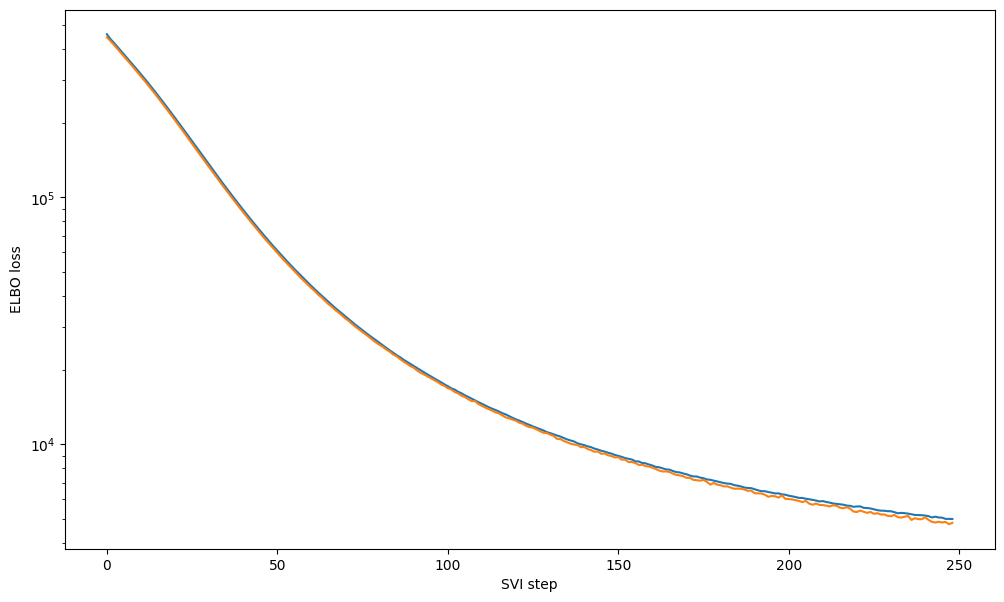

In [13]:
plt.figure(figsize=(12, 7))
plt.plot(train_losses)
plt.plot(val_losses)
plt.yscale("log")
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [22]:
import pyro
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from tqdm import tqdm

pyro.clear_param_store()
pyro.set_rng_seed(1)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

optimizer = Adam({"lr": 0.001})
bmodel = Unet(bayesian=True).to(device)
guide = AutoDiagonalNormal(bmodel).to(device)
elbo = Trace_ELBO()
svi = SVI(bmodel, guide, optimizer, loss=elbo)
train_losses = []
val_losses = []

# Early stopping parameters
patience = 10
tolerance = 100
best_val_loss = float("inf")
no_improvement_count = 0


for step in range(100):
    running_loss = 0
    for x, y in tqdm(dataloaders["train"]):
        x = x.to(device)
        y = y.to(device)
        svi.step(x, y)

    with torch.no_grad():
        loss = 0
        for x, y in tqdm(dataloaders["train"]):
            x = x.to(device)
            y = y.to(device)
            loss += svi.evaluate_loss(x, y)
        train_losses.append(loss / (BATCH_SIZE * len(dataloaders["train"])))

        loss = 0
        for x, y in tqdm(dataloaders["val"]):
            x = x.to(device)
            y = y.to(device)
            loss += svi.evaluate_loss(x, y)
        val_losses.append(loss / (BATCH_SIZE * len(dataloaders["val"])))

    print(
        "[iteration %04d] train loss: %.4f, val loss: %.4f"
        % (step + 1, train_losses[-1], val_losses[-1])
    )

    # Check for improvement
    if val_losses[-1] < best_val_loss - tolerance:
        best_val_loss = val_losses[-1]
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # Early stopping condition
    if no_improvement_count >= patience:
        print("Early stopping triggered at iteration %04d" % (step + 1))
        break

100%|██████████| 39/39 [00:04<00:00,  8.64it/s]


[iteration 0001] train loss: 12384791.1124, val loss: 12383254.6410


100%|██████████| 39/39 [00:04<00:00,  9.29it/s]


[iteration 0002] train loss: 10343664.0497, val loss: 10342269.6987


100%|██████████| 39/39 [00:04<00:00,  9.14it/s]


[iteration 0003] train loss: 8484077.5843, val loss: 8482332.9439


100%|██████████| 39/39 [00:04<00:00,  9.23it/s]


[iteration 0004] train loss: 6825651.1480, val loss: 6824619.4856


100%|██████████| 39/39 [00:04<00:00,  9.41it/s]


[iteration 0005] train loss: 5391294.2533, val loss: 5390420.6410


100%|██████████| 39/39 [00:04<00:00,  9.50it/s]


[iteration 0006] train loss: 4188805.3721, val loss: 4187265.9295


100%|██████████| 39/39 [00:04<00:00,  9.48it/s]


[iteration 0007] train loss: 3216639.8941, val loss: 3215112.8590


100%|██████████| 39/39 [00:04<00:00,  9.13it/s]


[iteration 0008] train loss: 2457592.3062, val loss: 2455828.0769


100%|██████████| 39/39 [00:04<00:00,  9.26it/s]


[iteration 0009] train loss: 1878405.6629, val loss: 1877528.8974


100%|██████████| 39/39 [00:04<00:00,  9.27it/s]


[iteration 0010] train loss: 1449726.0717, val loss: 1448116.7949


100%|██████████| 39/39 [00:04<00:00,  9.21it/s]


[iteration 0011] train loss: 1133377.5928, val loss: 1131626.0256


100%|██████████| 39/39 [00:04<00:00,  9.37it/s]


[iteration 0012] train loss: 903443.0293, val loss: 901610.3333


100%|██████████| 39/39 [00:04<00:00,  9.54it/s]


[iteration 0013] train loss: 733959.8111, val loss: 732596.8974


100%|██████████| 39/39 [00:04<00:00,  9.38it/s]


[iteration 0014] train loss: 608273.8111, val loss: 606626.4872


100%|██████████| 39/39 [00:04<00:00,  9.11it/s]


[iteration 0015] train loss: 512756.7459, val loss: 511601.4359


100%|██████████| 39/39 [00:04<00:00,  9.34it/s]


[iteration 0016] train loss: 439433.4397, val loss: 438669.0513


100%|██████████| 39/39 [00:04<00:00,  9.19it/s]


[iteration 0017] train loss: 381260.7264, val loss: 379071.7949


100%|██████████| 39/39 [00:04<00:00,  9.28it/s]


[iteration 0018] train loss: 335343.8208, val loss: 334605.2051


100%|██████████| 39/39 [00:04<00:00,  9.27it/s]


[iteration 0019] train loss: 297563.3681, val loss: 295458.1026


100%|██████████| 39/39 [00:04<00:00,  9.22it/s]


[iteration 0020] train loss: 266453.7036, val loss: 265176.0513


100%|██████████| 39/39 [00:04<00:00,  9.31it/s]


[iteration 0021] train loss: 240434.7883, val loss: 238636.6667


100%|██████████| 39/39 [00:04<00:00,  9.45it/s]


[iteration 0022] train loss: 218480.5179, val loss: 216958.2821


100%|██████████| 39/39 [00:04<00:00,  9.33it/s]


[iteration 0023] train loss: 200296.0163, val loss: 198672.0256


100%|██████████| 39/39 [00:04<00:00,  8.74it/s]


[iteration 0024] train loss: 184721.6645, val loss: 182767.7179


100%|██████████| 39/39 [00:04<00:00,  9.41it/s]


[iteration 0025] train loss: 170971.9283, val loss: 170029.4615


100%|██████████| 39/39 [00:04<00:00,  9.31it/s]


[iteration 0026] train loss: 159173.9935, val loss: 157892.5897


100%|██████████| 39/39 [00:04<00:00,  9.28it/s]


[iteration 0027] train loss: 149521.7166, val loss: 147471.2821


100%|██████████| 39/39 [00:04<00:00,  9.40it/s]


[iteration 0028] train loss: 140158.1922, val loss: 138042.8462


100%|██████████| 39/39 [00:04<00:00,  9.07it/s]


[iteration 0029] train loss: 132084.4430, val loss: 130243.1282


100%|██████████| 39/39 [00:04<00:00,  9.45it/s]


[iteration 0030] train loss: 124582.9772, val loss: 123081.5641


100%|██████████| 39/39 [00:04<00:00,  9.28it/s]


[iteration 0031] train loss: 118231.1107, val loss: 117434.0256


100%|██████████| 39/39 [00:04<00:00,  9.04it/s]


[iteration 0032] train loss: 113061.4137, val loss: 111390.7692


100%|██████████| 39/39 [00:04<00:00,  9.08it/s]


[iteration 0033] train loss: 107944.9316, val loss: 106817.4615


100%|██████████| 39/39 [00:04<00:00,  8.95it/s]


[iteration 0034] train loss: 103079.7948, val loss: 101160.5385


100%|██████████| 39/39 [00:04<00:00,  8.91it/s]


[iteration 0035] train loss: 99273.8893, val loss: 97768.7949


100%|██████████| 39/39 [00:04<00:00,  9.07it/s]


[iteration 0036] train loss: 95508.9511, val loss: 93852.7179


100%|██████████| 39/39 [00:04<00:00,  8.88it/s]


[iteration 0037] train loss: 92097.3485, val loss: 91117.8462


100%|██████████| 39/39 [00:04<00:00,  8.96it/s]


[iteration 0038] train loss: 88629.8893, val loss: 86777.8462


100%|██████████| 39/39 [00:04<00:00,  9.18it/s]


[iteration 0039] train loss: 85983.5733, val loss: 84137.9231


100%|██████████| 39/39 [00:04<00:00,  9.21it/s]


[iteration 0040] train loss: 83762.6417, val loss: 81813.3590


100%|██████████| 39/39 [00:04<00:00,  9.20it/s]


[iteration 0041] train loss: 80979.3290, val loss: 79434.4359


100%|██████████| 39/39 [00:04<00:00,  9.04it/s]


[iteration 0042] train loss: 78735.4332, val loss: 77938.6410


100%|██████████| 39/39 [00:04<00:00,  9.13it/s]


[iteration 0043] train loss: 76962.3388, val loss: 75629.1026


100%|██████████| 39/39 [00:04<00:00,  9.09it/s]


[iteration 0044] train loss: 74833.9121, val loss: 72282.0000


100%|██████████| 39/39 [00:04<00:00,  8.97it/s]


[iteration 0045] train loss: 73094.3160, val loss: 71280.2564


100%|██████████| 39/39 [00:04<00:00,  8.82it/s]


[iteration 0046] train loss: 71542.2736, val loss: 69635.1795


100%|██████████| 39/39 [00:04<00:00,  9.06it/s]


[iteration 0047] train loss: 70181.3681, val loss: 68508.4359


100%|██████████| 39/39 [00:04<00:00,  8.97it/s]


[iteration 0048] train loss: 68282.2476, val loss: 66479.8974


100%|██████████| 39/39 [00:04<00:00,  9.05it/s]


[iteration 0049] train loss: 67107.5961, val loss: 65342.5128


100%|██████████| 39/39 [00:04<00:00,  8.78it/s]


[iteration 0050] train loss: 65845.1238, val loss: 64425.1026


100%|██████████| 39/39 [00:04<00:00,  9.15it/s]


[iteration 0051] train loss: 64673.1238, val loss: 63528.6667


100%|██████████| 39/39 [00:04<00:00,  8.87it/s]


[iteration 0052] train loss: 63695.5081, val loss: 62020.8974


100%|██████████| 39/39 [00:04<00:00,  9.05it/s]


[iteration 0053] train loss: 62545.0521, val loss: 60968.9487


100%|██████████| 39/39 [00:04<00:00,  9.04it/s]


[iteration 0054] train loss: 61983.4072, val loss: 60306.9744


100%|██████████| 39/39 [00:04<00:00,  9.13it/s]


[iteration 0055] train loss: 61021.4104, val loss: 59197.4103


100%|██████████| 39/39 [00:04<00:00,  8.92it/s]


[iteration 0056] train loss: 59760.8697, val loss: 57935.9487


100%|██████████| 39/39 [00:04<00:00,  8.93it/s]


[iteration 0057] train loss: 59391.8827, val loss: 57756.4872


100%|██████████| 39/39 [00:04<00:00,  9.05it/s]


[iteration 0058] train loss: 58004.0912, val loss: 56933.6154


100%|██████████| 39/39 [00:04<00:00,  9.19it/s]


[iteration 0059] train loss: 57915.1759, val loss: 55363.6154


100%|██████████| 39/39 [00:04<00:00,  9.16it/s]


[iteration 0060] train loss: 57032.5863, val loss: 55037.8718


100%|██████████| 39/39 [00:04<00:00,  9.09it/s]


[iteration 0061] train loss: 56242.7492, val loss: 54575.5128


100%|██████████| 39/39 [00:04<00:00,  9.24it/s]


[iteration 0062] train loss: 55588.1270, val loss: 54199.7949


100%|██████████| 39/39 [00:04<00:00,  9.30it/s]


[iteration 0063] train loss: 54929.4560, val loss: 53119.9231


100%|██████████| 39/39 [00:04<00:00,  9.15it/s]


[iteration 0064] train loss: 54986.4788, val loss: 52820.8974


100%|██████████| 39/39 [00:04<00:00,  9.12it/s]


[iteration 0065] train loss: 54117.1564, val loss: 52176.7179


100%|██████████| 39/39 [00:04<00:00,  9.12it/s]


[iteration 0066] train loss: 53269.7459, val loss: 51336.2564


100%|██████████| 39/39 [00:04<00:00,  8.77it/s]


[iteration 0067] train loss: 53130.0033, val loss: 51006.1538


100%|██████████| 39/39 [00:04<00:00,  9.06it/s]


[iteration 0068] train loss: 52462.9642, val loss: 50865.5128


100%|██████████| 39/39 [00:04<00:00,  8.91it/s]


[iteration 0069] train loss: 52065.8958, val loss: 50446.1795


100%|██████████| 39/39 [00:04<00:00,  9.32it/s]


[iteration 0070] train loss: 51292.5179, val loss: 49336.4872


100%|██████████| 39/39 [00:04<00:00,  9.28it/s]


[iteration 0071] train loss: 51409.0489, val loss: 50016.0000


100%|██████████| 39/39 [00:04<00:00,  9.16it/s]


[iteration 0072] train loss: 51066.8241, val loss: 49298.3077


100%|██████████| 39/39 [00:04<00:00,  9.05it/s]


[iteration 0073] train loss: 50528.6450, val loss: 48027.5897


100%|██████████| 39/39 [00:04<00:00,  9.28it/s]


[iteration 0074] train loss: 50083.5309, val loss: 48759.2051


100%|██████████| 39/39 [00:04<00:00,  9.24it/s]


[iteration 0075] train loss: 49884.8664, val loss: 48311.8462


100%|██████████| 39/39 [00:04<00:00,  9.44it/s]


[iteration 0076] train loss: 49596.7427, val loss: 47019.2821


100%|██████████| 39/39 [00:04<00:00,  9.46it/s]


[iteration 0077] train loss: 49656.6287, val loss: 48101.2051


100%|██████████| 39/39 [00:04<00:00,  9.29it/s]


[iteration 0078] train loss: 48827.7948, val loss: 46540.9744


100%|██████████| 39/39 [00:04<00:00,  9.37it/s]


[iteration 0079] train loss: 48783.4984, val loss: 47329.6923


100%|██████████| 39/39 [00:04<00:00,  9.34it/s]


[iteration 0080] train loss: 48388.1010, val loss: 46712.8205


100%|██████████| 39/39 [00:04<00:00,  9.16it/s]


[iteration 0081] train loss: 48061.5798, val loss: 46444.5385


100%|██████████| 39/39 [00:04<00:00,  9.31it/s]


[iteration 0082] train loss: 47887.5081, val loss: 45910.6154


100%|██████████| 39/39 [00:04<00:00,  9.60it/s]


[iteration 0083] train loss: 47874.1173, val loss: 46904.1282


100%|██████████| 39/39 [00:04<00:00,  9.38it/s]


[iteration 0084] train loss: 47869.8111, val loss: 45731.7692


100%|██████████| 39/39 [00:04<00:00,  9.06it/s]


[iteration 0085] train loss: 47165.4593, val loss: 45334.5128


100%|██████████| 39/39 [00:04<00:00,  9.28it/s]


[iteration 0086] train loss: 47247.7264, val loss: 44849.2308


100%|██████████| 39/39 [00:04<00:00,  9.47it/s]


[iteration 0087] train loss: 46839.8241, val loss: 45651.4103


100%|██████████| 39/39 [00:04<00:00,  9.33it/s]


[iteration 0088] train loss: 46833.1075, val loss: 44791.3333


100%|██████████| 39/39 [00:04<00:00,  9.30it/s]


[iteration 0089] train loss: 46720.1596, val loss: 44103.4872


100%|██████████| 39/39 [00:04<00:00,  9.14it/s]


[iteration 0090] train loss: 46367.1531, val loss: 44005.2821


100%|██████████| 39/39 [00:04<00:00,  9.36it/s]


[iteration 0091] train loss: 45868.4593, val loss: 43946.0256


100%|██████████| 39/39 [00:04<00:00,  9.27it/s]


[iteration 0092] train loss: 46069.5700, val loss: 44216.5128


100%|██████████| 39/39 [00:04<00:00,  9.44it/s]


[iteration 0093] train loss: 45910.4528, val loss: 43756.4103


100%|██████████| 39/39 [00:04<00:00,  9.30it/s]


[iteration 0094] train loss: 45938.6971, val loss: 44103.1282


100%|██████████| 39/39 [00:04<00:00,  9.25it/s]


[iteration 0095] train loss: 45971.2280, val loss: 44549.3846


100%|██████████| 39/39 [00:04<00:00,  9.34it/s]


[iteration 0096] train loss: 45411.7068, val loss: 43250.4872


100%|██████████| 39/39 [00:04<00:00,  9.44it/s]


[iteration 0097] train loss: 45223.4267, val loss: 43008.3333


100%|██████████| 39/39 [00:04<00:00,  9.29it/s]


[iteration 0098] train loss: 45139.0782, val loss: 43294.2564


100%|██████████| 39/39 [00:04<00:00,  9.51it/s]


[iteration 0099] train loss: 44895.1042, val loss: 43331.6154


100%|██████████| 39/39 [00:04<00:00,  9.35it/s]

[iteration 0100] train loss: 44928.2932, val loss: 42312.7949


In [29]:
import pickle

with open("train.pkl", "wb") as f:
    pickle.dump(train_losses, f)
with open("val.pkl", "wb") as f:
    pickle.dump(val_losses, f)

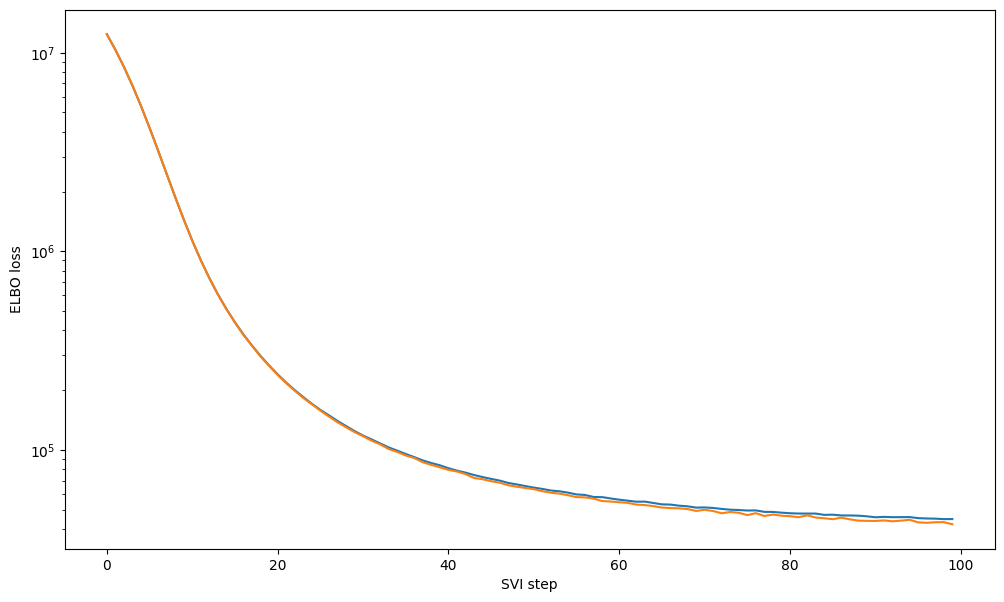

In [27]:
plt.figure(figsize=(12, 7))
plt.plot(train_losses)
plt.plot(val_losses)
plt.yscale("log")
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

# Measure metric

In [ ]:
from pyro.inference import Predictive
predictive = Predictive(
    model, guide, 10
)

In [12]:
from torchmetrics.classification import Precision, Recall

prn = Precision(task="binary", num_classes=1).to("cuda")
rec = Recall(task="binary", num_classes=1).to("cuda")
model = model.to("cuda")
ts = np.linspace(0.1, 0.9, 30)
dice_scores = []
prn_scores = []
rec_scores = []
for t in ts:
    for x, y in tqdm(dataloaders["test"]):
        x = x.to("cuda")
        y = y.to("cuda")
        pred = predictive(x)["obs"].mean(dim=0)
        pred = (pred > t).float()
        prn(pred, y)
        rec(pred, y)
    prn_scores.append(prn.compute().item())
    rec_scores.append(rec.compute().item())

100%|██████████| 10/10 [00:53<00:00,  5.33s/it]


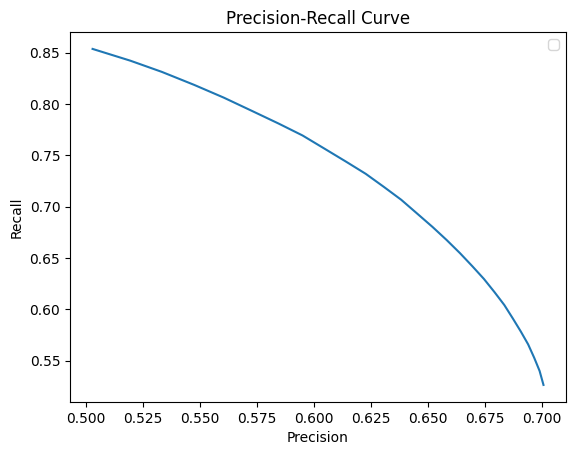

Площадь под кривой (AUC-PR): 0.2073


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

precision = np.asarray(prn_scores[3:])
recall = np.asarray(rec_scores[3:])

# Построение графика
plt.plot(precision, recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Вычисление площади под кривой (AUC-PR)
pr_auc = auc(recall, precision)
print(f"Площадь под кривой (AUC-PR): {pr_auc:.4f}")